### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import glob
import time
import copy
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
import ta
# import tsfresh as tsf
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
# d(r)L
import tensorflow as tf

from stable_baselines import PPO2, DQN, A2C
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines.common import make_vec_env

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
init_notebook_mode(connected=True)

##### Local

In [7]:
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Indicators, _Indicators, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest , SingleAssetEnv

##### Functions

In [9]:
def get_weights(size, method='linear', *args):
    if method in ['linear', 'lin']:
        return np.arange(1, size+1)
    elif method in ['exponential', 'exp']:
        a, b = args
        return a**np.linspace(0, b, size)
    return np.ones(size)

### Initialization

In [10]:
cred = Cred()

In [11]:
bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'AAVE', 'ATOM', 'EOS', 'AVAX', 'XEM', 'XTZ', 'BTT', 'NEO', 'ALGO', 'CHZ', 'DASH', 'SNX', 'MKR', 'COMP', 'BAT', 'ZEC', 'ETC', 'UMA', 'WAVES', 'YFI', 'ZRX', 'ONT', 'REN', 'DGB', 'OMG', 'QTUM', 'LSK', 'OCEAN', 'KNC', 'REP', 'BAND', 'KMD', 'ANT', 'DOGE', 'ENJ', 'LTO', 'THETA']

In [12]:
quotes_or_assets = []
quotes_or_assets += [_+'USDT' for _ in bases]
# quotes_or_assets += [_+'BTC' for _ in bases if _ != 'BTC']

In [13]:
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_indicators = None #[_ for _ in Kline._store_indicators_default if _[0] not in ('obv')]
store_signals = None
# store_signals = [
#     ('crossovers', ('sma_50', 'sma_200')),
#     ('trend', ('sma_50', 2)),
#     ('pricecross', ('sma_50',)),
#     ('macdcross', (12, 26)),
#     ('rsicross', (14, 30, 70)),
#     ('rsicross2', ())
# ]

In [14]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path,
                store_indicators=store_indicators, store_signals=store_signals)

In [ ]:
_ = [klmngr[_].signalsjar.set_raw() for _ in klmngr]

In [15]:
kline = klmngr['ETHUSDT']

In [ ]:
kline.plot(24*30*4, signals=kline.signals, signal_type='buy')

### Update

In [17]:
print(datetime.utcnow().replace(microsecond=0))

2021-06-12 09:54:06


In [18]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

Timestamp('2021-06-12 09:00:00')

In [ ]:
klmngr.update(verbose=2)

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

### Preprocessing

##### Artificial USDT

### Baseline

Single asset

In [32]:
kline = klmngr['ETHUSDT']

In [ ]:
# In below sigs calculations there is NO need to SHIFT values:
#     You take signals info up to current hour close for a .step (which results in an action in the next hour).
#     Thus no future info is used.
#     Start index should be 0 though.

In [33]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
# _sigs = kline.signals.eq(1).mean(axis=1).rolling(6).mean().values[:-1]
#sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))

In [34]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

In [ ]:
btst_ref = copy.deepcopy(btst) # For matching env tests.

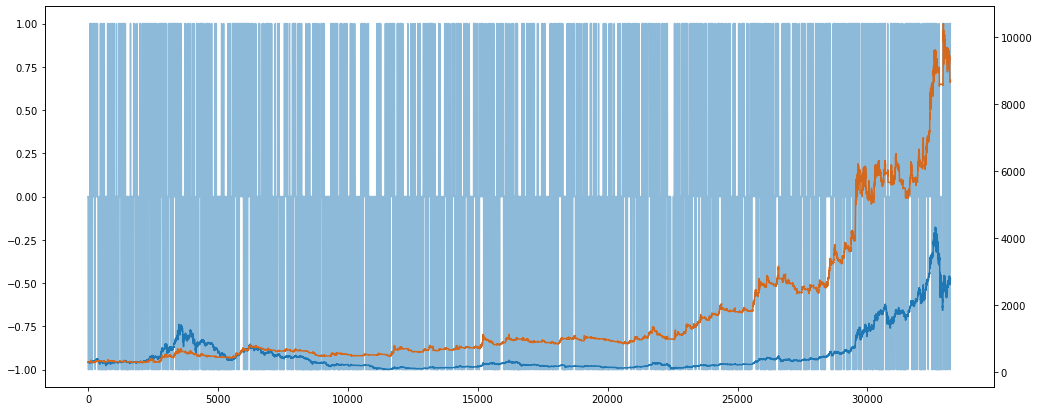

In [427]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

Random part of a single asset

In [16]:
kline = klmngr['ETHUSDT']

In [80]:
kline_part = kline.loc[np.random.choice(kline.index):].iloc[:24*30*2]

In [81]:
_sigs = kline_part.signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
#sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))

In [82]:
btst = Backtest(kline_part, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

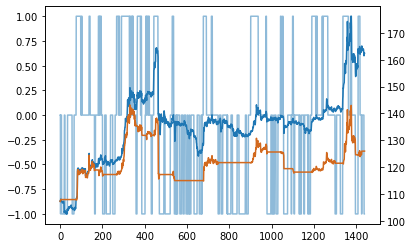

In [83]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

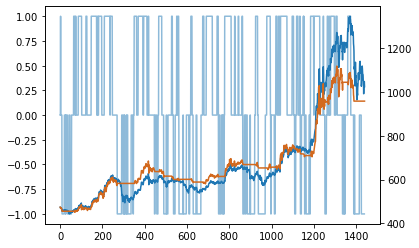

In [79]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

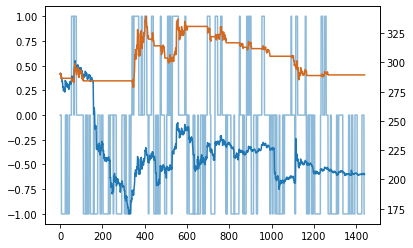

In [75]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

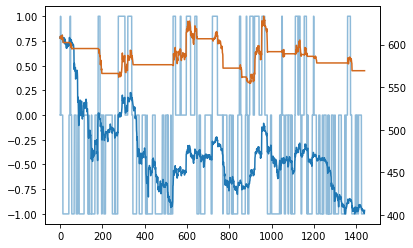

In [71]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

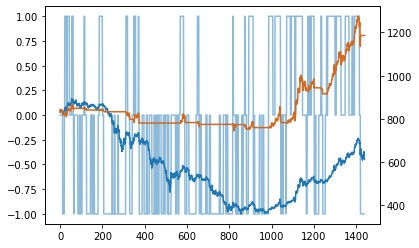

In [67]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

### Model test 2: RF

##### Manual reloads

In [20]:
from cryptoast.model.agents import SingleAssetEnv

In [21]:
from stable_baselines.common.policies import FeedForwardPolicy, ActorCriticPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP

##### Testing ground

- Mathcing SingleAssetEnv results with simple Backtest results: passed

In [396]:
btst = Backtest(kline=klmngr['ETHUSDT'], init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0, memory=6)
env = SingleAssetEnv(klmngr, assets=['ETHUSDT'], backtest=btst, window=3, episode_steps=24*30*12*5, randomize_start=False, allow_gaps=True)

In [397]:
def get_action(obs):
    mean = np.median((obs[:-12].reshape(-1, 3).T==1).mean(1))
    action = 2 if mean >= .55 else (0 if mean < .2 else 1)
    return mean, action

In [398]:
done = False
obs = env.reset()
means = []
while not done:
    try:
        mean, action = get_action(obs)
        obs, reward, done, info = env.step(action)
        means.append(mean)
    except Exception as e:
        print(e)
        pass

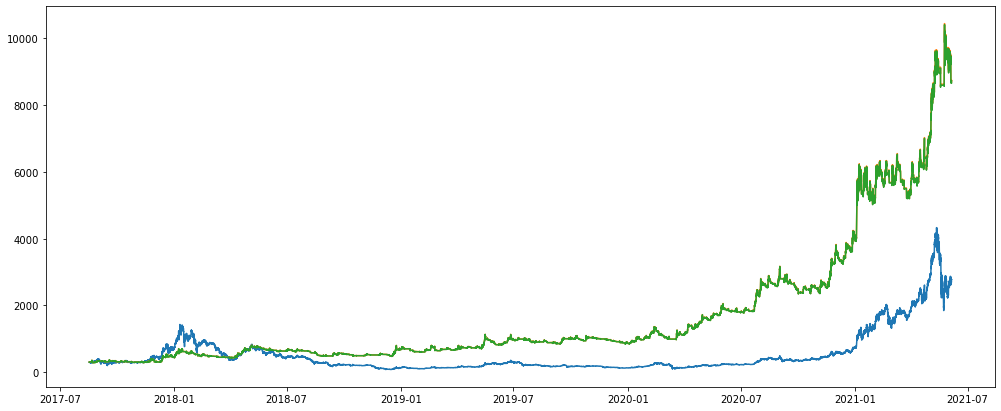

In [399]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(env.kline.loc[btst.periodic.index].close)
ax.plot(btst.periodic.value)
ax.plot(btst_ref.periodic.value)

- Miscellaneous tests: check_env, reward design, ...

In [22]:
# asset = np.random.choice(klmngr.assets)
asset = 'ETHUSDT'
kline = klmngr[asset]
btst = Backtest(kline=kline, init_assets=1, memory=24, commission=0.001, slippage_pct=0.1, slippage_steps=0)
env = SingleAssetEnv(klmngr, assets=[asset], backtest=btst, window=3, episode_steps=24*30*12*5, randomize_start=False, allow_gaps=True)

100


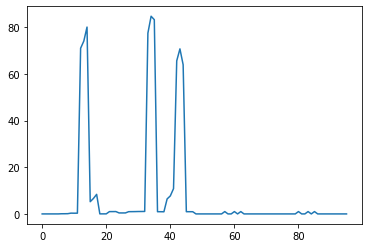

In [23]:
# obs = env.step(np.random.choice([0, 1, 2]))[0]
obs = [env.step(_) for _ in np.random.choice([0, 1, 2], size=100)][-1][0]
print(env.current_step)
plt.plot(obs)

In [24]:
check_env(env)

In [108]:
obs = env.reset()

In [143]:
action = 0

In [131]:
action = 2

{'cash': 318.77392504366014, 'assets': 0.0, 'value': 318.77392504366014}
-0.009479925026556243


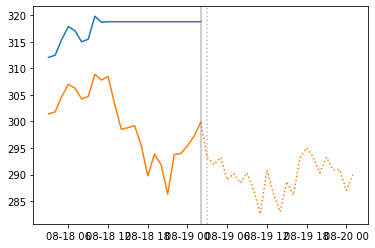

In [158]:
obs, reward, _, __ = env.step(action)
timestamp = env.backtest.position['timestamp']
plt.plot(env.backtest.periodic.value[:timestamp].iloc[-24:], c='C0')
plt.plot(env.kline.close[:timestamp].iloc[-24:], c='C1')
plt.plot(env.kline.close[timestamp:].iloc[:24], c='C1', linestyle=':')
plt.axvline(timestamp, c='grey', alpha=.5)
plt.axvline(timestamp+pd.Timedelta(hours=1), c='grey', alpha=.5, linestyle=':')
action = 1
print(env.backtest._periodic[env.backtest.position['timestamp']])
print(reward)

##### Defining assets

- Check for uniform shape within indicators and define train assets

In [ ]:
bad_assets = [asset for asset in klmngr.assets if klmngr[asset].indicators.columns.size != 34]
print(bad_assets)

- Define pool of train assets

In [ ]:
train_assets = list(set(klmngr.assets)-set(test_assets)-set(bad_assets))

##### RL Training and Testing

- Define

In [159]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [160]:
train_assets = ['ETHUSDT']

In [161]:
test_assets = train_assets

In [162]:
window = 6
memory = 24
episode_steps = 24*30*2
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0.1, slippage_steps=0, memory=memory)
env_kwargs = dict(klmngr=klmngr,
                  assets=train_assets,
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=episode_steps)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [163]:
checkpoint_callback = CheckpointCallback(save_freq=episode_steps*10, save_path='../models/h5/',
                                         name_prefix='checkpoint_model')

eval_callback = EvalCallback(env, 
                             best_model_save_path='../models/h5/',
                             log_path='../models/logs/',
                             n_eval_episodes=5,
                             eval_freq=episode_steps*10,
                             deterministic=True, 
                             render=False)

callback_list = CallbackList([checkpoint_callback, eval_callback])

In [164]:
total_timesteps = 500*1000
tensorboard_log = '../models/logs_tensorboard/' # None
# model = DQN(policy='MlpPolicy', env=env, exploration_fraction=.2, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1, tensorboard_log=tensorboard_log)
# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)

model = DQN(policy=CustomDQNPolicy, env=env, gamma=.999, prioritized_replay=True, train_freq=episode_steps//10, tensorboard_log=tensorboard_log, verbose=1)
# model = PPO2(policy='MlpPolicy', env=env, verbose=1, tensorboard_log=tensorboard_log, gamma=.9)
# model = A2C(policy='MlpPolicy', env=env, verbose=1)

In [233]:
checkpoint_filepaths = glob.glob('../models/h5/checkpoint*.zip')
checkpoint_max = max([int(_.split('_')[-2]) for _ in checkpoint_filepaths])
load_path = [_ for _ in checkpoint_filepaths if int(_.split('_')[-2]) == checkpoint_max][0]
print(load_path)

../models/h5\checkpoint_model_493600_steps.zip


In [234]:
# model.load(load_path='../models/h5/best_model.zip', env=env)
model.load(load_path=load_path, env=env)

In [235]:
# model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')
model.load_parameters(load_path_or_dict=load_path)

- Train

In [ ]:
# model.learn(total_timesteps)
model.learn(total_timesteps, callback=callback_list)

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\stable_baselines\common\callbacks.py:287: UserWarning:

Training and eval env are not of the same type<stable_baselines.common.base_class._UnvecWrapper object at 0x000001D6DD072E08> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001D6E41F6288>



Eval num_timesteps=8000, episode_reward=-0.33 +/- 0.18
Episode length: 906.80 +/- 528.25
Eval num_timesteps=22400, episode_reward=-0.32 +/- 0.18
Episode length: 764.80 +/- 533.94
Eval num_timesteps=36800, episode_reward=-0.02 +/- 0.03
Episode length: 988.00 +/- 495.97
Eval num_timesteps=51200, episode_reward=-0.05 +/- 0.05
Episode length: 532.00 +/- 578.85
Eval num_timesteps=65600, episode_reward=-0.41 +/- 0.14
Episode length: 950.20 +/- 357.30
Eval num_timesteps=80000, episode_reward=-0.25 +/- 0.15
Episode length: 873.20 +/- 391.46
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 100      |
| mean 100 episode reward | -0.2     |
| steps                   | 84597    |
--------------------------------------
Eval num_timesteps=94400, episode_reward=-0.42 +/- 0.17
Episode length: 1057.80 +/- 475.76
Eval num_timesteps=108800, episode_reward=-0.12 +/- 0.15
Episode length: 533.40 +/- 505.48
Eval num_timesteps=123200, episode_reward=-0.

In [214]:
env_kwargs.update(dict(assets=test_assets,
                       backtest=btst,
                       datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
                       randomize_start=False,
                       allow_gaps=True,
                       episode_steps=-1,
                      )
                 )
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [221]:
model.load(load_path='../models/h5/best_model.zip', env=env)

In [222]:
model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')

In [223]:
n_steps = klmngr[test_assets[0]].loc[btst.position['timestamp']:].shape[0]
print(n_steps)

12677


In [224]:
vec_env = not(isinstance(env, SingleAssetEnv))
print(vec_env)

True


In [225]:
obs = env.reset()
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
#     action_proba = model.action_probability(obs)[0]
#     if action_proba[2]/action_proba[[0, 2]].sum() > .55:
#         action = 2
#     else:
#         if action_proba[0]/action_proba[[0, 2]].sum() < .2:
#             action = 0
#         else:
#             action = 1
#     action = np.array([action])
    action, _ = model.predict(obs, deterministic=False)
#     action = [np.random.choice([0, 1, 2], p=model.action_probability(obs)[0])]
    obs, reward, done, info = env.step(action)
    if vec_env:
        reward_list.append(reward[0])
        action_list.append(action[0])
        values_dict = {**values_dict, **info[0]['periodic']}
    else:
        reward_list.append(reward)
        action_list.append(action)
        values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
    # if step%1000==0:
    #     print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= [-4.99436e-07]


In [226]:
pd.value_counts(action_list)

1    4307
0    4253
2    4115
dtype: int64

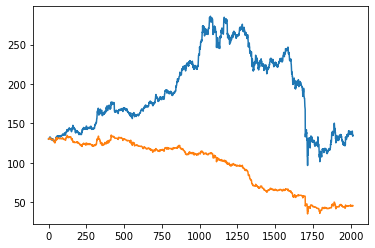

In [227]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

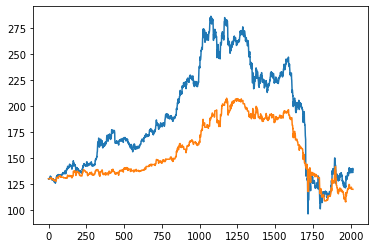

In [102]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

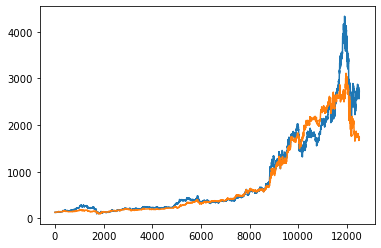

In [40]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

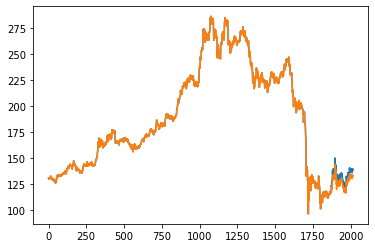

In [122]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

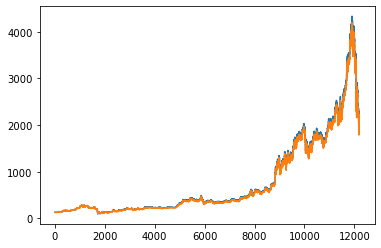

In [123]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

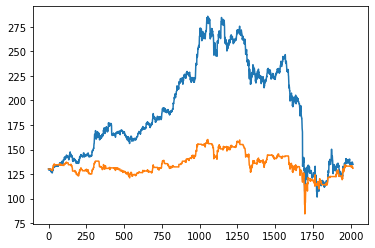

In [161]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

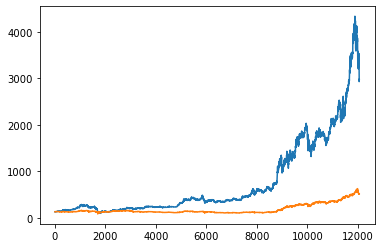

In [162]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

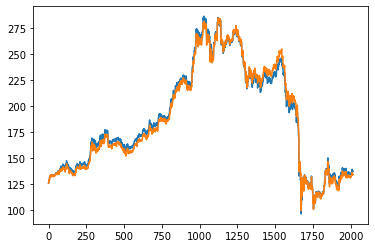

In [28]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

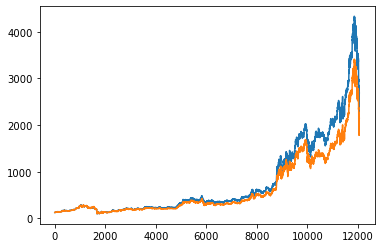

In [29]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

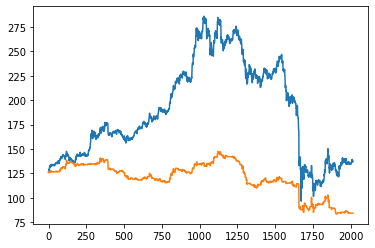

In [75]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

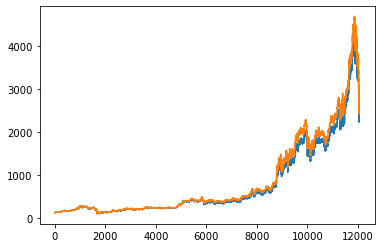

In [37]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

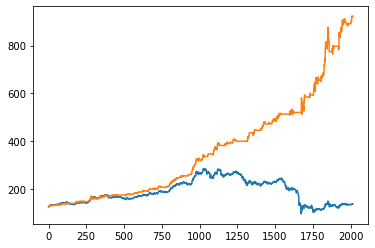

In [41]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


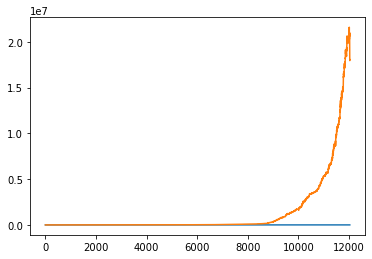

In [42]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

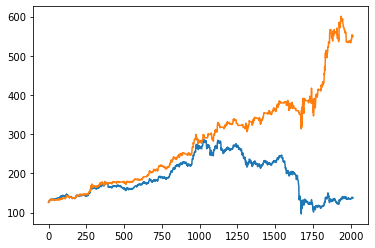

In [36]:
# PPO new
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


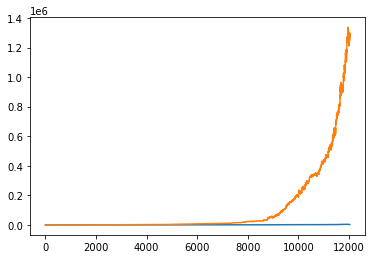

In [35]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


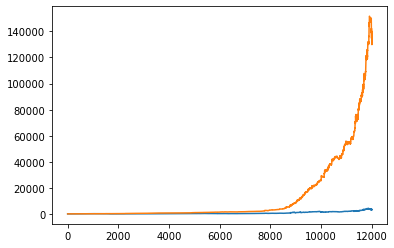

In [152]:
# PPO load
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

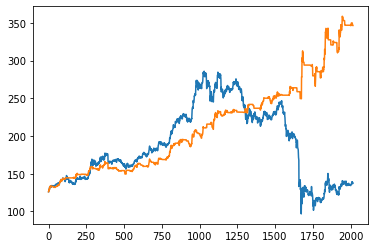

In [153]:
# PPO load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

<AxesSubplot:>

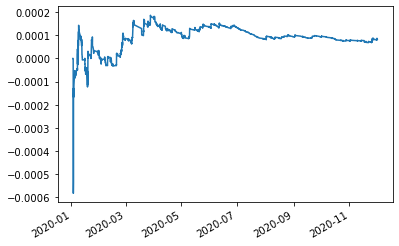

In [133]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

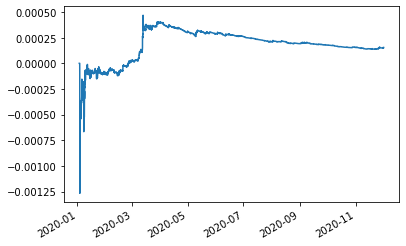

In [194]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

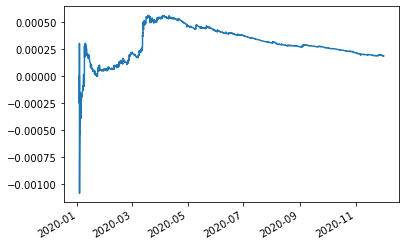

In [220]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

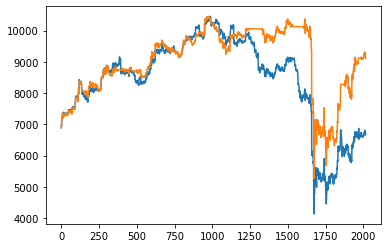

In [129]:
# DQN
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

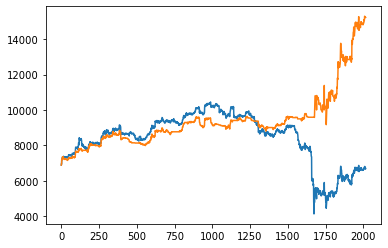

In [195]:
# PPO last
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

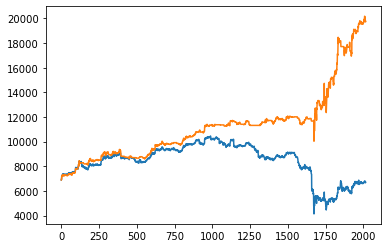

In [221]:
# PPO best
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

250K


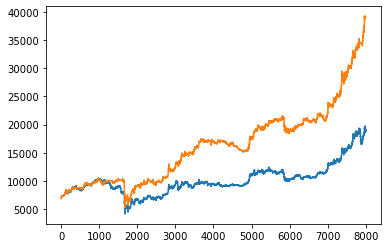

In [112]:
# DQN
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


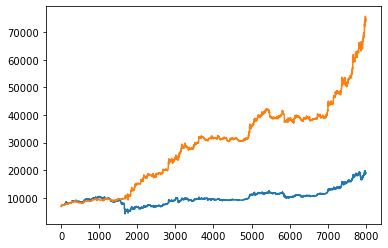

In [196]:
# PPO last
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


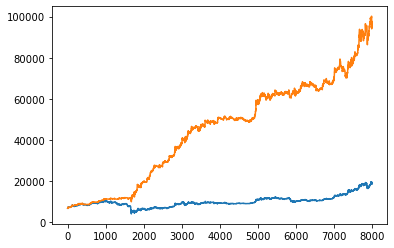

In [222]:
# PPO best
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)